In [47]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, BatchNorm, relu, Chain, ADAM, RMSProp, Descent, params, throttle, Dropout, @epochs, testmode!

using Base.Iterators: repeated

using DataFrames, DataFramesMeta, ExcelFiles, MLDataUtils, HDF5, ProgressMeter, Plots, LinearAlgebra, NNlib
pyplot() # pyplot backend

using BSON: @save, @load

include("flux_functions.jl")
include("flux_train.jl")


train_nn

# DATA IMPORT

In [46]:
path_data = "./data/DataSet_0p20val.hdf5"

X_columns = h5read(path_data, "X_columns")

X_entropy_train = h5read(path_data, "X_entropy_train")
y_entropy_train = h5read(path_data, "y_entropy_train")

X_entropy_valid = h5read(path_data, "X_entropy_valid")
y_entropy_valid = h5read(path_data, "y_entropy_valid")

X_entropy_test = h5read(path_data, "X_entropy_test")
y_entropy_test = h5read(path_data, "y_entropy_test")

X_train = h5read(path_data, "X_train")
y_train = h5read(path_data, "y_train")

X_valid = h5read(path_data, "X_valid")
y_valid = h5read(path_data, "y_valid")

X_test = h5read(path_data, "X_test")
y_test = h5read(path_data, "y_test")

# Loading viscous Tg
X_tg_train = h5read(path_data,"X_tg_train")
X_tg_valid= h5read(path_data,"X_tg_valid")
X_tg_test = h5read(path_data,"X_tg_test")

y_tg_train = h5read(path_data,"y_tg_train")
y_tg_valid = h5read(path_data,"y_tg_valid")
y_tg_test = h5read(path_data,"y_tg_test")

X_raman_train = Float32.(h5read("./data/NKAS_DataSet.hdf5","X_raman_train"))
y_raman_train = Float32.((h5read("./data/NKAS_DataSet.hdf5","y_raman_train")))
X_raman_valid = Float32.(h5read("./data/NKAS_DataSet.hdf5","X_raman_test"))
y_raman_valid = Float32.((h5read("./data/NKAS_DataSet.hdf5","y_raman_test")))

println("loaded")
println("\nFeatures in X_ arrays are")
println(X_columns)
println("\nShape of X train and valid is")
println(size(X_train))
println(size(X_valid))

print("Size of Raman datasets")
print(size(X_raman_train))
print(size(y_raman_train))
print(size(X_raman_valid))
print(size(y_raman_valid))

# Loading density dataset
X_density_train = Float32.(h5read("./data/NKAS_density.hdf5","X_density_train"))
X_density_valid = Float32.(h5read("./data/NKAS_density.hdf5","X_density_valid"))
X_density_test = Float32.(h5read("./data/NKAS_density.hdf5","X_density_test"))

y_density_train = Float32.(h5read("./data/NKAS_density.hdf5","y_density_train"))
y_density_valid = Float32.(h5read("./data/NKAS_density.hdf5","y_density_valid"))
y_density_test = Float32.(h5read("./data/NKAS_density.hdf5","y_density_test"))

# Loading fake dataset
X_FragLoss = Float32.(h5read("./data/X_FragLoss.hdf5","X_gen"))

ap_FragLoss = ap(X_FragLoss)
b_FragLoss = b(X_FragLoss)

loaded

Features in X_ arrays are
["sio2", "al2o3", "na2o", "k2o", "nbot", "ifsm", "ifst", "ap", "b", "T", "Sc", "tg"]

Shape of X train and valid is
(12, 1010)
(12, 261)
Size of Raman datasets(4, 31)(850, 31)(4, 14)(850, 14)

6×500 Array{Float32,2}:
 0.916066    0.645725    0.880421    …    0.680829    0.780332   0.868319  
 0.0229449   0.00230098  0.048718         0.183133    0.100855   0.0340221 
 0.0176651   0.0264171   0.0373085        0.0344455   0.0558159  0.0611097 
 0.0433237   0.325557    0.0335526        0.101592    0.0629973  0.0365494 
 3.40383     7.02434     1.29481        -13.9553     -4.37427    3.2135    
 0.00284735  0.00535427  0.00512356  …    0.0188726   0.0105047  0.00378504

1×500 Array{Float64,2}:
 0.00284689  0.00535422  0.00512259  …  0.0188689  0.0105027  0.00378436

# Model

In [32]:
# The model

#
# With two subnetworks for Be and Sc
#

nb_neurons = 100
p_drop = 0.3

nb_channels_raman = size(y_raman_train,1)

c1 = Dense(4, nb_neurons, relu)
c2 = Dense(nb_neurons, nb_neurons, relu)
c3 = Dense(nb_neurons, nb_neurons, relu)
c4 = Dense(nb_neurons, nb_neurons, relu)
c5 = Dense(nb_neurons, nb_neurons, relu)

cout_thermo = Dense(nb_neurons, 4,initb=init_both) #initW = glorot_uniform
cout_raman =  Dense(nb_neurons,nb_channels_raman)

core = Chain(c1, Dropout(p_drop),
    c2, Dropout(p_drop),
    c3, Dropout(p_drop))
    #c4, Dropout(p_drop))

mr = Chain(core, cout_raman) # |> gpu
m1 = Chain(core, cout_thermo) # |> gpu

# Other stuffs
Ae = param([-1.5])



Tracked 1-element Array{Float64,1}:
 -1.5

In [33]:
X_entro_train, y_entro_train_, T_entro_train_, ap_entro_train_, b_entro_train_, sc_train, tg_sc_train = prepare_data(X_entropy_train,X_entropy_train[11,:])
X_entro_valid, y_entro_valid_, T_entro_valid_, ap_entro_valid_, b_entro_valid_, sc_valid, ~ = prepare_data(X_entropy_valid,X_entropy_valid[11,:])


(Float32[0.71 0.71 … 0.75 0.75; 0.0 0.0 … 0.02 0.02; 0.0 0.0 … 0.23 0.23; 0.29 0.29 … 0.0 0.0], Float32[9.60972 9.60972 … 7.47 7.47], Float32[750.0 770.0 … 1763.0 1773.0], Float32[6.54256 6.54256 … 8.88602 8.88602], Float32[0.0045762 0.0045762 … 0.001886 0.001886], Float32[9.60972 9.60972 … 7.47 7.47], Float32[727.0 727.0 … 744.0 744.0])

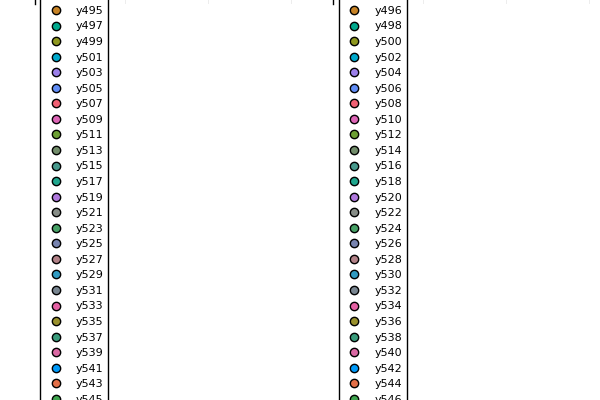

In [7]:
testmode!(m1)
testmode!(mr)

scatter([y_tg_train,y_density_train'], # x values
            [tg(X_tg_train,m1).data[:],density(X_density_train,m1).data[:]], # y values
            layout=2)

scatter!([y_tg_valid,y_density_valid'], # x values
            [tg(X_tg_valid,m1).data[:],density(X_density_valid,m1).data[:]], # y values
            layout=2)

# Pre-train on Raman

In [34]:
# SC training
record_loss_raman_train = Float64[]
record_loss_raman_valid = Float64[]

testmode!(mr,false)

# loop details
epoch_idx = 1; nb_epoch = 2000
optimal_epochs_s = 0; early_stop = 1; patience = 100
min_loss_val = 30000000.0

dataset_raman = [(X_raman_train,y_raman_train, mr)]

p = ProgressMeter.Progress(patience, 1)   # minimum update interval: 1 second
while early_stop < patience

    evalcb = () -> (push!(record_loss_raman_train, loss_raman(X_raman_train, y_raman_train, mr).data),
                    push!(record_loss_raman_valid, loss_raman(X_raman_valid, y_raman_valid, mr).data))
    Flux.train!(loss_raman, params(mr), dataset_raman, ADAM(0.001), cb = throttle(evalcb, 1))

    # Early stopping criterion
    if record_loss_raman_valid[epoch_idx] < min_loss_val
        early_stop = 0
        optimal_epochs = epoch_idx
        min_loss_val = record_loss_raman_valid[epoch_idx]
    else
        early_stop += 1
    end
    
    ProgressMeter.update!(p, early_stop)
    epoch_idx += 1
    
end

print(mean(record_loss_raman_train[end-20:end]))
print("\n")
print(mean(record_loss_raman_valid[end-20:end]))
print("\n")

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:02

2.7780516261146184
3.072849602926345


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


2.7780516261146184
3.072849602926345


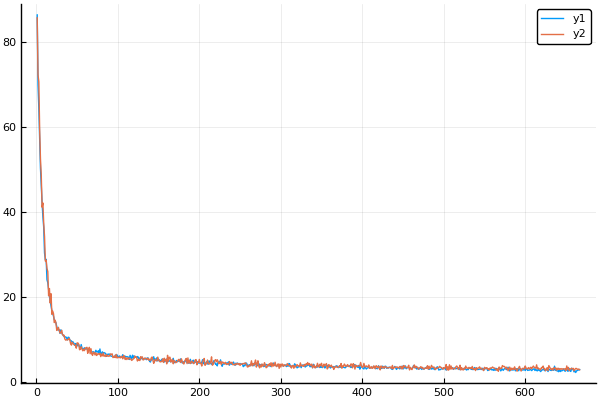

In [35]:
print(mean(record_loss_raman_train[end-20:end]))
print("\n")
print(mean(record_loss_raman_valid[end-20:end]))
print("\n")
plot(record_loss_raman_train)
plot!(record_loss_raman_valid)

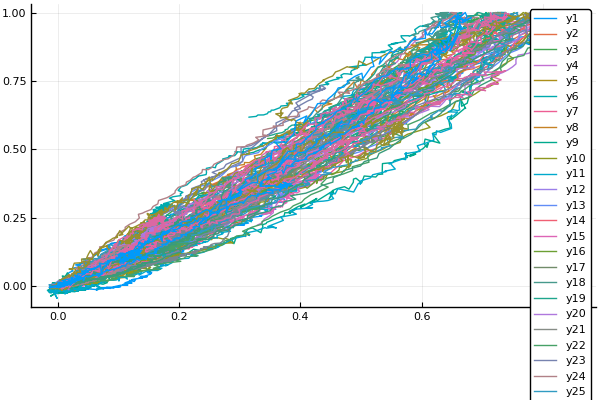

In [36]:
testmode!(mr)
plot(mr(X_raman_train).data[:,:],y_raman_train)

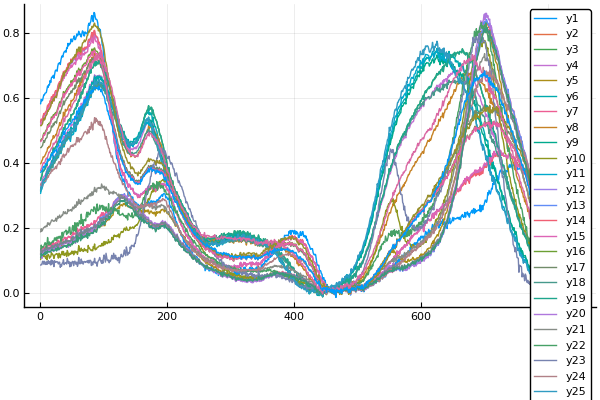

In [37]:
plot(mr(X_raman_train).data[:,:])

# Pre-train on only density + Tg

In [38]:
# SC training

# loss function

#### Now entropy pre-training

# record loss
record_loss_d_train = Float64[]
record_loss_d_valid = Float64[]

# loop details
epoch_idx = 1; optimal_epochs_s = 0;
early_stop = 1; patience = 10
min_loss_val = 30000000.0

# loop
p = ProgressMeter.Progress(patience, 1)   # minimum update interval: 1 second
while early_stop < patience

    evalcb = () -> (push!(record_loss_d_train, loss_density(X_density_train, y_density_train,m1).data),
        push!(record_loss_d_valid, loss_density(X_density_valid, y_density_valid, m1).data))

    Flux.train!(loss_density, params(m1), [(X_density_train, y_density_train,m1)], ADAM(0.001), cb = throttle(evalcb, 1))

    ProgressMeter.update!(p, early_stop)

    # Early stopping criterion
    if record_loss_d_valid[epoch_idx] < min_loss_val
        early_stop = 0
        optimal_epochs = epoch_idx
        min_loss_val = record_loss_d_valid[epoch_idx]
    else
        early_stop += 1
    end
    epoch_idx += 1
end

println("density loss")
println(mean(record_loss_d_train[end-20:end]))
println(mean(record_loss_d_valid[end-20:end]))


Progress:  10%|████▏                                    |  ETA: 0:00:09

density loss
0.029699999422759228
0.0349265907401719


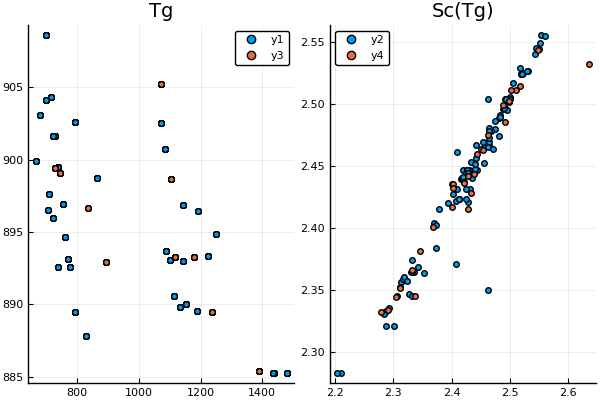

In [40]:
testmode!(m1)
testmode!(mr)

scatter([y_tg_train',y_density_train'],
    [tg(X_tg_train,m1).data[:],density(X_density_train,m1).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])
scatter!([y_tg_valid',y_density_valid'],
    [tg(X_tg_valid,m1).data[:],density(X_density_valid,m1).data[:]])

   

In [41]:
function loss_tg_d_sc(X_tg, y_tg, X_d, y_d, x_s, y_s, nns)
    return 100.0.*loss_density(X_d,y_d,nns) .+ loss_tg(X_tg, y_tg,nns) .+ 10.0.*loss_sc(x_s,y_s, nns)
end

loss_tg_d_sc(X_tg_train, y_tg_train, 
                X_density_train, y_density_train,
                X_entro_train, sc_train,
                m1).data

290.47645735163144

In [42]:

#### Now entropy pre-training

#X_entro_train, y_entro_train_, T_entro_train_, ap_entro_train_, b_entro_train_, sc_train,

testmode!(m1,false)
testmode!(mr,false)

# record loss
record_loss_tg_train = Float64[]
record_loss_tg_valid = Float64[]

# loop details
epoch_idx = 1; optimal_epochs_s = 0;
early_stop = 1; patience = 500
min_loss_val = 30000000.0

# loop
p = ProgressMeter.Progress(patience, 1)   # minimum update interval: 1 second
while early_stop < patience

    evalcb = () -> (push!(record_loss_tg_train, loss_tg_d_sc(X_tg_train, y_tg_train, 
                X_density_train, y_density_train,
                X_entro_train, sc_train,
                m1).data),
        push!(record_loss_tg_valid, loss_tg_d_sc(X_tg_valid, y_tg_valid, 
                X_density_valid, y_density_valid, 
                X_entro_valid, sc_valid,
                m1).data))

    Flux.train!(loss_tg_d_sc, params(m1,Ae), [(X_tg_train, y_tg_train,
                X_density_train, y_density_train,
                X_entro_train, sc_train,
                m1)], ADAM(0.01), cb = throttle(evalcb, 1))

    ProgressMeter.update!(p, early_stop)

    # Early stopping criterion
    if record_loss_tg_valid[epoch_idx] < min_loss_val
        early_stop = 0
        optimal_epochs = epoch_idx
        min_loss_val = record_loss_tg_valid[epoch_idx]
    else
        early_stop += 1
    end
    epoch_idx += 1
end

println("Tg-density loss")
println(mean(record_loss_tg_train[end-20:end]))
println(mean(record_loss_tg_valid[end-20:end]))


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

Tg-density loss
185.89162650725595
174.26495208458397


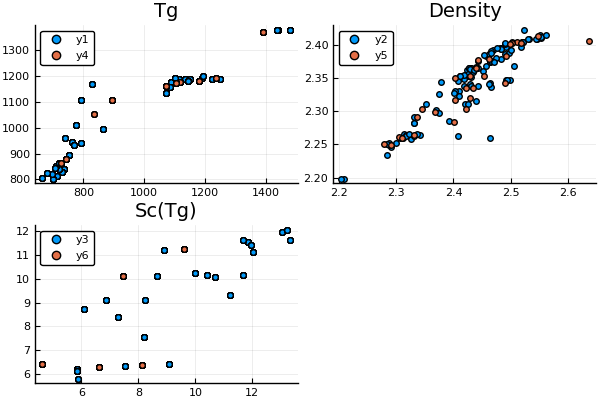

In [43]:
testmode!(m1)

testmode!(mr)

scatter([y_tg_train',y_density_train',sc_train'],
    [tg(X_tg_train,m1).data[:],density(X_density_train,m1).data[:],ScTg(X_entro_train, m1).data[:]],
    layout=3, title=["Tg" "Density" "Sc(Tg)"])
# scatter!([y_tg_valid,y_density_valid'],
#     [tg(X_tg_valid,m1).data[:],density(X_density_valid,m1).data[:]])

   scatter!([y_tg_valid',y_density_valid',sc_valid'],
    [tg(X_tg_valid,m1).data[:],density(X_density_valid,m1).data[:],ScTg(X_entro_valid, m1).data[:]],
    layout=3, title=["Tg" "Density" "Sc(Tg)"])

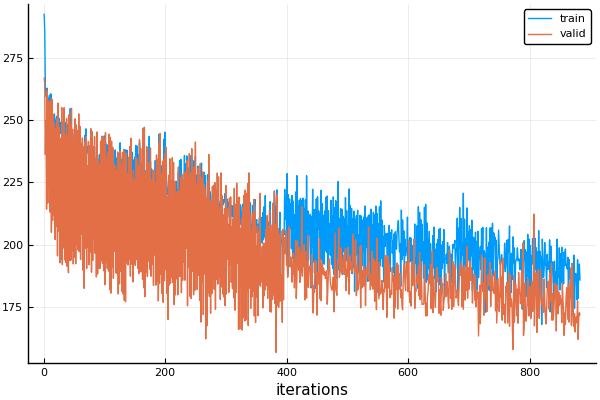

In [44]:
testmode!(m1)
testmode!(mr)
# Plot
plot([record_loss_tg_train],label="train",xlabel="iterations")
plot!(record_loss_tg_valid,label="valid")

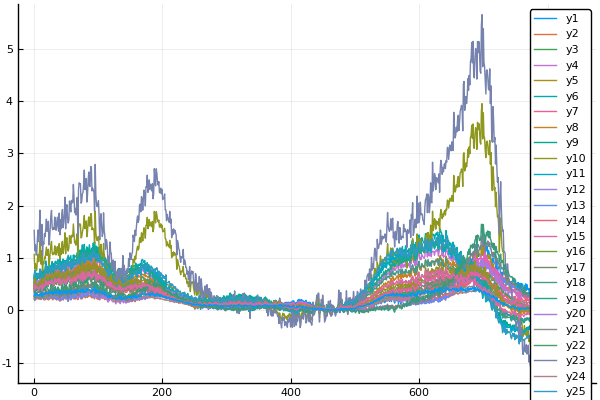

In [61]:
plot(mr(X_raman_train).data[:,:])

# Train on loss global : entropy + viscosity

In [20]:
x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid,y_valid)

x_entro_train_, y_entro_train_, T_entro_train_, ap_entro_train_, b_entro_train_, sc_entro_train_, tg_entro_train_ = prepare_datas(X_entropy_train,X_entropy_train[11,:])
x_entro_valid_, y_entro_valid_, T_entro_valid_, ap_entro_valid_, b_entro_valid_, sc_entro_valid_, tg_entro_valid_ = prepare_datas(X_entropy_valid,X_entropy_valid[11,:])

print("\nloss Raman: $(loss_raman(X_raman_train, y_raman_train))")
print("\nloss tg: $(loss_tg(x_entro_train_, tg_entro_train_))")
print("\nloss sc: $(loss_sc(x_entro_train_, sc_entro_train_))")
print("\nloss n train: $(loss_n(x_train_, T_train_ ,ap_train_, b_train_, y_train_))")
print("\nloss myega train: $(loss_n_myega(x_train_, T_train_ , y_train))")

L2_norm = 0.1
loss_global(x, T, ap, b, y_target, x2, tg2_target, sc2_target, x_raman, y_raman) = 
    loss_n(x, T, ap, b, y_target) .+ 
    loss_n_myega(x,T,y_target) .+
    #loss_f(x)+
    0.1.*loss_tg(x2,tg2_target) .+ 
    loss_sc(x2,sc2_target) .+
    0.01.*loss_raman(x_raman, y_raman) .+
    L2_norm*sum(norm, params(m1))



loss Raman: 40.614741571801616 (tracked)
loss tg: 35.0807484250026 (tracked)
loss sc: 0.6193387590647911 (tracked)
loss n train: 0.8698906687014094 (tracked)
loss myega train: 3.6140051115194534 (tracked)

loss_global (generic function with 1 method)

In [21]:
record_loss_train = Float64[]
record_loss_valid = Float64[]
    
testmode!(m1,false)
testmode!(mr,false)

epoch_idx = 1; optimal_epochs_s = 0; 
early_stop = 1; patience = 20
min_loss_val = 30000000.0; max_epoch = 4000

p = ProgressMeter.Progress(max_epoch, 1)   # minimum update interval: 1 second

dataset = [(x_train_, T_train_ ,ap_train_, b_train_, y_train_,
                x_entro_train_, tg_entro_train_, sc_entro_train_,X_raman_train, y_raman_train)]

while epoch_idx < max_epoch
    
    evalcb = () -> (push!(record_loss_train, loss_global(x_train_, T_train_ ,ap_train_, b_train_, y_train_,
                x_entro_train_, tg_entro_train_, sc_entro_train_,X_raman_train, y_raman_train).data),
                push!(record_loss_valid, loss_global(x_valid_, T_valid_ ,ap_valid_, b_valid_, y_valid_,
                x_entro_valid_, tg_entro_valid_, sc_entro_valid_,X_raman_valid, y_raman_valid).data))
    Flux.train!(loss_global, params(Ae,m1,mr,ab_f), dataset, ADAM(0.001), cb = throttle(evalcb, 1))

    ProgressMeter.update!(p, epoch_idx)

    # Early stopping criterion
    if record_loss_valid[epoch_idx] < min_loss_val
        early_stop = 0
        optimal_epochs = epoch_idx
        min_loss_val = record_loss_valid[epoch_idx]
        @save "./model/m1.bson" m1
        @save "./model/mr.bson" mr
        @save "./model/Ae.bson" Ae
    else
        early_stop += 1
    end
    epoch_idx += 1
    
end

Progress:  16%|██████▋                                  |  ETA: 0:36:58m

InterruptException: InterruptException:

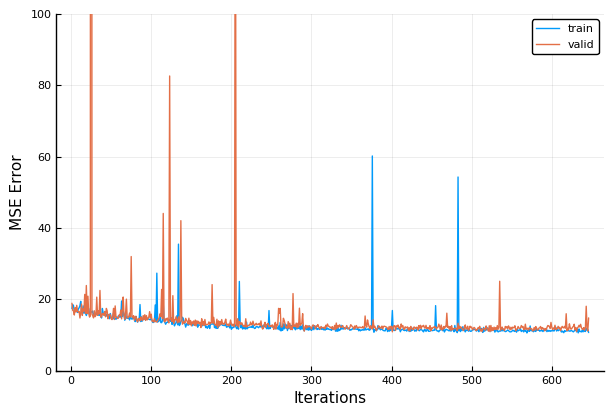

In [22]:
testmode!(m1)
#println("Optimal number of epochs:", optimal_epochs)
#println("Min loss val:", min_loss_val)
# Plot
plot([record_loss_train],layout=1,label="train", ylabel="MSE Error", xlabel="Iterations", ylim=(0,100))
plot!(record_loss_valid,label="valid")
savefig("./figures/training_error_record.png")

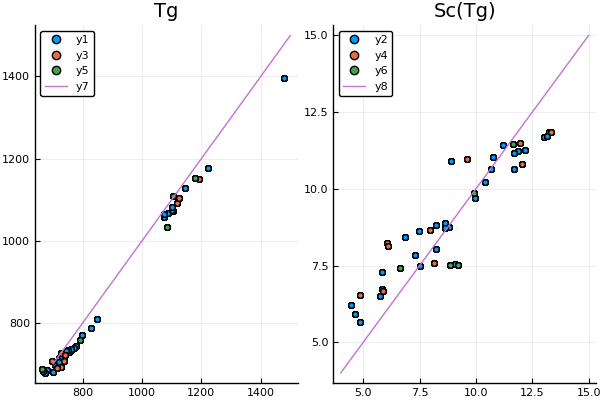

In [23]:
testmode!(m1)
scatter([X_entropy_train[12,:],X_entropy_train[11,:]],
    [tg(X_entropy_train).data[:],ScTg(X_entropy_train).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

scatter!([X_entropy_valid[12,:],X_entropy_valid[11,:]],
    [tg(X_entropy_valid).data[:],ScTg(X_entropy_valid).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

scatter!([X_entropy_test[12,:],X_entropy_test[11,:]],
    [tg(X_entropy_test).data[:],ScTg(X_entropy_test).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

plot!([[700;1500] [4;15]],[[700;1500] [4;15]])

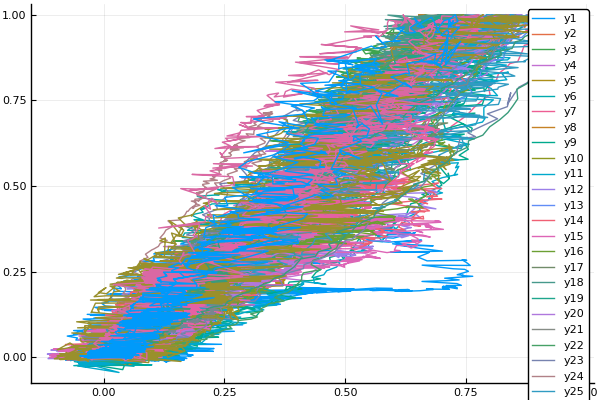

In [24]:
plot(mr(X_raman_train).data[:,:],y_raman_train)

In [25]:
scatter(y_train_[:],
    model(x_train_,T_train_,ap_train_, b_train_).data[:],)
scatter!(y_valid_[:],
    model(x_valid_,T_valid_,ap_valid_, b_valid_).data[:],)
plot!([0.,16.],[0.,16.],ylim=(0,16))

print("\nAdam-Gibbs\n")
print("\nloss n train: $(loss_n(x_train_, T_train_ ,ap_train_, b_train_, y_train_))")
print("\nloss n valid: $(loss_n(x_valid_, T_valid_ ,ap_valid_, b_valid_, y_valid_))")
print("\nMYEGA\n")
print("\nloss n train: $(loss_n_myega(x_train_, T_train_ , y_train_))")
print("\nloss n valid: $(loss_n_myega(x_valid_, T_valid_ , y_valid_))")


Adam-Gibbs

loss n train: 0.6175058974615347 (tracked)
loss n valid: 0.8036231752838714 (tracked)
MYEGA

loss n train: 0.6344258538143294 (tracked)
loss n valid: 0.9274915840792997 (tracked)

In [47]:
@save "./model/m1.bson" m1
@save "./model/Ae.bson" Ae

# Visualizing

# Fragility against Sconf(Tg)

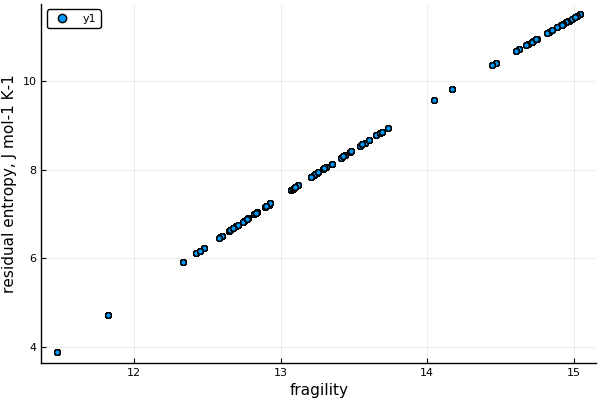

In [25]:
scatter(fragility(x_train_).data[:],ScTg(x_train_).data[:],xlabel="fragility",ylabel="residual entropy, J mol-1 K-1")

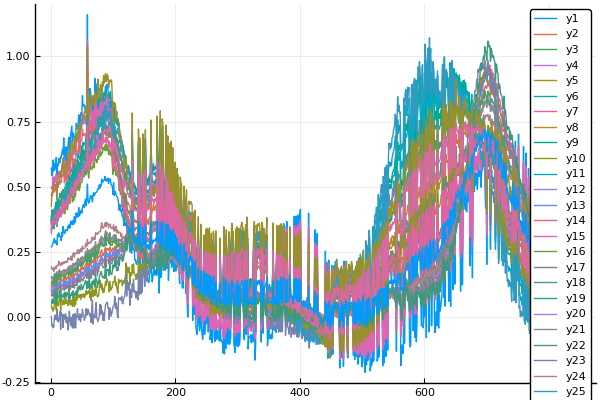

In [34]:
plot(mr(X_raman_train).data[:,:])

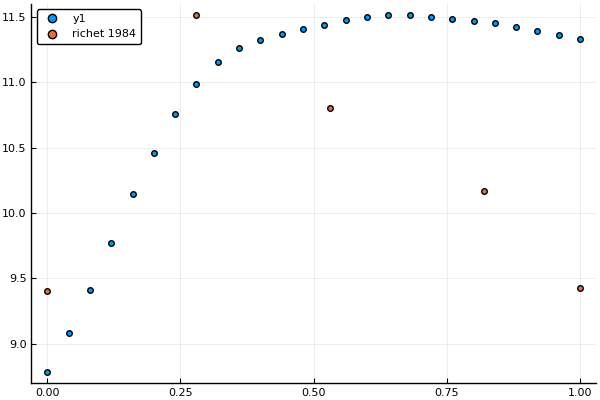

In [27]:
na2o = collect(0.:0.01:0.25)
k2o = 0.25.-na2o
sio2 = ones(size(na2o,1)).*0.75
al2o3 = zeros(size(na2o,1))
dummy = zeros(size(na2o,1))
T = ones(size(na2o,1)).*1000.0

X_visu_NKS = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

scatter(X_visu_NKS[4,:]./(X_visu_NKS[3,:].+X_visu_NKS[4,:]),ScTg(X_visu_NKS).data'[:],layout=1)
scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,label="richet 1984")
#scatter!(X_visu_NKS[4,:]./(X_visu_NKS[3,:].+X_visu_NKS[4,:]),tg(X_visu_NKS).data'[:],layout=2)

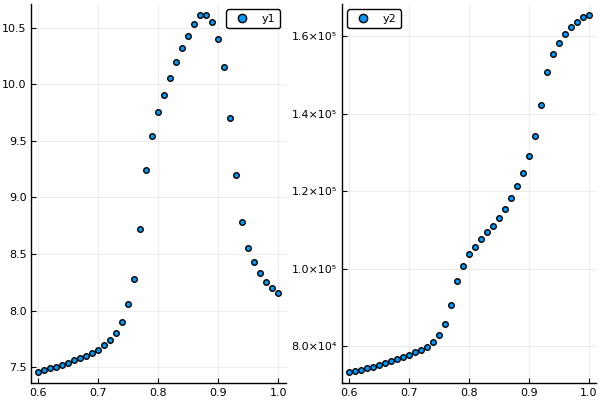

In [103]:
sio2 = collect(0.6:0.01:1.)
al2o3 = zeros(size(sio2,1))
na2o = 1.0.-sio2
k2o = zeros(size(sio2,1))
dummy = zeros(size(sio2,1))
T = ones(size(sio2,1)).*1000.0
X_visu_NS = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

X_visu_NS_sc = copy(X_visu_NS)

for i = 1:7
    X_visu_NS_sc[i,:] = (X_visu_NS_sc[i,:].- X_scaler_mean[i])./sqrt.(X_scaler_var[i]) 
end
#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

scatter([X_visu_NS[1,:],X_visu_NS[1,:]],
    [ScTg(X_visu_NS).data'[:],Be(X_visu_NS).data'[:]],
layout=2)
